# Fitting a 3 variable based non-linear equation using a 3 layered neural network:

## Equation:
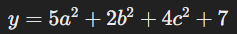

One of the youtubers (Josh Starmer) that I follow: A neural network does nothing but fits a squiggle to the data.

As squiggle is continuous, it's said that any continuous data in theory.  

Just a random equation I came up with.

I'll keep this equation consistent over all the examples. For easier comparision.

In [ ]:
import numpy as np
import pandas as pd

np.random.seed(7)

# Generate random values
a_values = np.random.uniform(-10, 10, 500)
b_values = np.random.uniform(-10, 10, 500)
c_values = np.random.uniform(-10, 10, 500)
y_values = 5*a_values**2 + 2*b_values**2 + 4*c_values**2 + 7

df = pd.DataFrame({'a': a_values, 'b': b_values, 'c': c_values, 'y': y_values})

x = df.drop('y', axis=1).to_numpy()
y = df['y'].to_numpy().reshape(-1, 1)

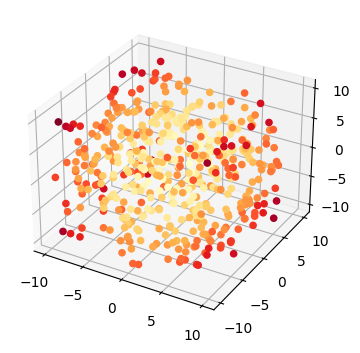

In [ ]:
# 4d plot as in the reference notes: The problem with this is the discretion is based on the color /
# and it's not quite human to identify the non-linearity or how the actual curve would look through this graph

from matplotlib import pyplot as plt
import numpy as np
plt.rcParams["figure.figsize"] = [7.00, 3.50]
plt.rcParams["figure.autolayout"] = True
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
img = ax.scatter(a_values, b_values, c_values, c=y, cmap='YlOrRd', alpha=1)
plt.show()

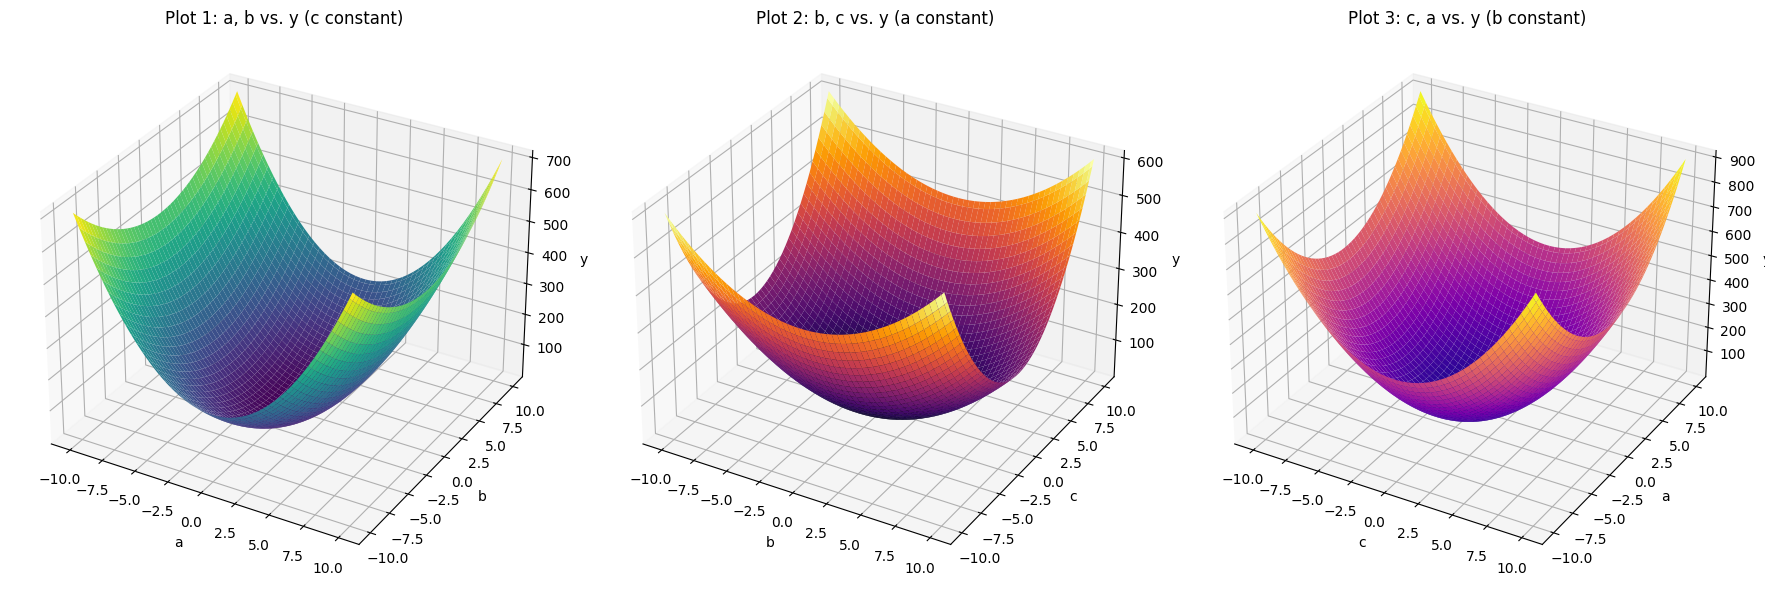

In [ ]:
# Generate a grid of values for 'a', 'b', and 'c' based on the base equation
# and plot them accordingly, keeping one variable constant in each plot.
import matplotlib.pyplot as plt

a_grid, b_grid = np.meshgrid(np.linspace(-10, 10, 100), np.linspace(-10, 10, 100))
x_a, x_b, x_c = x[:, 0], x[:, 1], x[:, 2]
a_median, b_median, c_median = np.median(x_a), np.median(x_b), np.median(x_c)


# Keeping 'c' constant at its median value for the first plot
c_constant = c_median
y_grid1 = 5*a_grid**2 + 2*b_grid**2 + 4*c_constant**2 + 7

fig = plt.figure(figsize=(18, 6))

# Plot 1: 'a', 'b' vs 'y' with 'c' constant
ax1 = fig.add_subplot(131, projection='3d')
ax1.plot_surface(a_grid, b_grid, y_grid1, cmap='viridis')
ax1.set_xlabel('a')
ax1.set_ylabel('b')
ax1.set_zlabel('y')
ax1.set_title('Plot 1: a, b vs. y (c constant)')

a_median = np.median(x_a)
# Keeping 'a' constant at its median value for the second plot
a_constant = a_median
y_grid2 = 5*a_constant**2 + 2*b_grid**2 + 4*a_grid**2 + 7  # Using 'a_grid' as 'c' for variation

ax2 = fig.add_subplot(132, projection='3d')
ax2.plot_surface(b_grid, a_grid, y_grid2, cmap='inferno')  # Swapping 'b' and 'c' roles
ax2.set_xlabel('b')
ax2.set_ylabel('c')
ax2.set_zlabel('y')
ax2.set_title('Plot 2: b, c vs. y (a constant)')

# Keeping 'b' constant at its median value for the third plot
b_constant = b_median
y_grid3 = 5*a_grid**2 + 2*b_constant**2 + 4*b_grid**2 + 7  # Using 'b_grid' as 'c' for variation

ax3 = fig.add_subplot(133, projection='3d')
ax3.plot_surface(a_grid, b_grid, y_grid3, cmap='plasma')  # Swapping 'b' and 'c' roles again
ax3.set_xlabel('c')
ax3.set_ylabel('a')
ax3.set_zlabel('y')
ax3.set_title('Plot 3: c, a vs. y (b constant)')

plt.tight_layout()
plt.show()

In [ ]:
class Linear:
    def __init__(self, input_dim: int, num_hidden: int):
        self.weights = np.random.randn(input_dim, num_hidden) * np.sqrt(2. / input_dim)
        self.bias = np.zeros((1, num_hidden))

    def __call__(self, x):
        self.x = x
        return x @ self.weights + self.bias

    def backward(self, gradient):
        self.weights_gradient = self.x.T @ gradient / self.x.shape[0]
        self.bias_gradient = np.mean(gradient, axis=0, keepdims=True)
        return gradient @ self.weights.T

    def update(self, lr):
        self.weights -= lr * self.weights_gradient
        self.bias -= lr * self.bias_gradient

In [ ]:
class Relu:
    def __call__(self, input_):
        self.input_ = input_
        return np.maximum(0, input_)

    def backward(self, output_gradient):
        return (self.input_ > 0) * output_gradient

In [ ]:
class MSE:
    def __call__(self, y_pred, y_true):
        self.y_pred = y_pred
        self.y_true = y_true
        return np.mean((y_pred - y_true) ** 2)

    def backward(self):
        return 2. * (self.y_pred - self.y_true) / self.y_pred.shape[0]

In [ ]:
class Model:
    def __init__(self, input_dim, num_hidden1, num_hidden2):
        self.linear1 = Linear(input_dim, num_hidden1)
        self.relu1 = Relu()
        self.linear2 = Linear(num_hidden1, num_hidden2)
        self.relu2 = Relu()
        self.linear3 = Linear(num_hidden2, 1)

    def __call__(self, x):
        x = self.linear1(x)
        x = self.relu1(x)
        x = self.linear2(x)
        x = self.relu2(x)
        x = self.linear3(x)
        return x

    def backward(self, output_gradient):
        gradient = self.linear3.backward(output_gradient)
        gradient = self.relu2.backward(gradient)
        gradient = self.linear2.backward(gradient)
        gradient = self.relu1.backward(gradient)
        self.linear1.backward(gradient)

    def update(self, lr):
        self.linear1.update(lr)
        self.linear2.update(lr)
        self.linear3.update(lr)


In [ ]:
def fit(x, y, model, loss, lr, num_epochs):
    for epoch in range(num_epochs):
        y_pred = model(x)
        loss_value = loss(y_pred, y)
        gradient_from_loss = loss.backward()
        model.backward(gradient_from_loss)
        model.update(lr)

        if epoch % 100 == 0:
            print(f'Epoch {epoch}, Loss {loss_value}')

In [ ]:
model = Model(3, 20, 20)
loss = MSE()

# Train the Model
fit(x, y, model, loss, lr=0.01, num_epochs=50000)

Epoch 0, Loss 184735.52993080404
Epoch 100, Loss 5157.166075002514
Epoch 200, Loss 4659.1099540953055
Epoch 300, Loss 4316.2891711410075
Epoch 400, Loss 4002.253949891425
Epoch 500, Loss 3706.1788877859713
Epoch 600, Loss 3406.780360649313
Epoch 700, Loss 3080.492184659687
Epoch 800, Loss 2747.3604971898103
Epoch 900, Loss 2411.698918950176
Epoch 1000, Loss 2065.412853960026
Epoch 1100, Loss 1724.4375065672953
Epoch 1200, Loss 1422.3536584202075
Epoch 1300, Loss 1171.8967846242665
Epoch 1400, Loss 982.7478715000277
Epoch 1500, Loss 836.2307205859446
Epoch 1600, Loss 722.1343897250208
Epoch 1700, Loss 635.3447755123955
Epoch 1800, Loss 569.7303221682763
Epoch 1900, Loss 509.4553693483991
Epoch 2000, Loss 457.774029828746
Epoch 2100, Loss 417.5343472153271
Epoch 2200, Loss 387.7499681954216
Epoch 2300, Loss 438.93373691030115
Epoch 2400, Loss 416.239293772386
Epoch 2500, Loss 620.2363114024475
Epoch 2600, Loss 438.72814729977284
Epoch 2700, Loss 508.46428901663705
Epoch 2800, Loss 447.56

In [ ]:
y_pred = model(x)

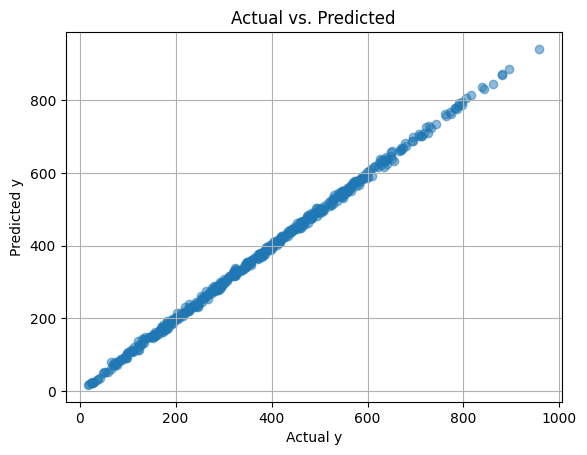

In [ ]:
import matplotlib.pyplot as plt

# Plotting the actual y vs. predictions
plt.scatter(y, y_pred, alpha=0.5)
plt.title('Actual vs. Predicted')
plt.xlabel('Actual y')
plt.ylabel('Predicted y')
plt.grid(True)
plt.show()